# Sarcasm Detection Using BERT 

In this project, we will use the BERT model on the Multimodal Sarcasm Detection Dataset to classify tweets as sarcastic or otherwise. The model will 
be fine-tuned for a few epochs, after which you’ll evaluate it.


In [1]:
## Task 1: Import Libraries

In this task, we will start by importing the Python modules used in the project. To complete this task, import the following libraries:

1. pandas: This package is used for data manipulation and analysis.
    
2. seaborn: This library is required for plotting confusion matrices as heatmaps.
    
3. numpy: This package is required for number crunching in Python.
    
4. tensorflow: This package is required for the training and inference of deep learning models.
    
5. re: This module is used to preprocess the text data.
    
6. tensorflow_hub: This library is required for access to the pretrained BERT model.
    
7. tensorflow-text: This library is used in the preprocessing model from the TensorFlow Hub.
    
8. optimization: This is a submodule of the official.nlp package, which provides methods for building machine learning projects in TensorFlow. 
It is required for creating the AdamW optimizer.
    
9. pyplot: This is a submodule of the matplotlib library and is required for plotting the training curves.
    
10. rcParams: This method is from the matplotlib module and is required for setting the plot size.
    
11. keras: This package is required for creating the deep learning model using high-level functionality.
    
12. Dense: This is a submodule of the keras.layers package and is required for creating dense classification layers in the deep learning model.
    
13. model_from_json: This is a method of the tensorflow.keras.models package and is required for loading the trained model.
    
14. math: This module is used for mathematical operations in Python.
                             
15. classification_report and confusion_matrix: These modules are from the sklearn.metrics package and are required for model evaluation.
                             
16. os: This module is used to hide warnings.



SyntaxError: invalid syntax (1834683860.py, line 3)

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import re
import tensorflow_hub as hub
import tensorflow_text
from official.nlp import optimization 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
from keras.layers import Dense
from tensorflow.keras.models import model_from_json
import math
from sklearn.metrics import classification_report,confusion_matrix
import os

tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Task 2: Load Dataset

The first step is usually to load the data and split it into training and test sets. In this case, the splitting has already been done. The dataset
is made available as three files named train.csv, test.csv, and validate.csv in the /usercode directory. Each of the three files has two columns named 
text and labels. The text column contains the text of tweets, while the label column indicates if the tweet is sarcastic or not.

To complete this task, perform the following steps:

1. Load the text column of the three CSV files into DataFrames named X_train, X_test, and X_valid.

2. Load the labels column of the three CSV files into DataFrames named Y_train, Y_test, and Y_valid.

3. Display the X_train DataFrame using the DataFrame.head() command.


In [3]:
train = pd.read_csv('./usercode/train.csv')
test = pd.read_csv('./usercode/test.csv')
val = pd.read_csv('./usercode/validate.csv')
X_train = train[["text"]].copy()
X_test = test[["text"]].copy()
X_val = val[["text"]].copy()
Y_train = train[["labels"]].copy()
Y_test = test[["labels"]].copy()
Y_val = val[["labels"]].copy()
X_train.head()

,text
0,<user> thanks for showing up for our appointme...
1,haha . # lol
2,i love waiting <num> min for a cab - such shor...
3,22 super funny quotes # funnyquotes # funnysa...
4,goog morning # sorrynotsorry # morning


## Task 3: Pre-process Data

Now that the data has been loaded, preprocess the tweets so that they:

Include only lowercase, alphanumeric characters.

Are of the string data type.
    
Do not contain the rt (retweet) tag.
    
To complete this task, perform the following steps:

1. Define the preprocess function as follows:

Use the astype() method to convert the data type of the text column to string data type.

Use the lower() function within the apply() method to convert the text column to lowercase.
    
Use the sub() method of the re package within the apply() method to remove non-alphanumeric characters from the text column.

Remove the retweet tag, rt, from the text.
    
2. Use the preprocess function to preprocess the text of the tweets in the X_train, X_val, and X_test DataFrames.


In [22]:
def preprocess(data):
  data = data.astype(str)
  data = data.apply(lambda x: x.lower())
  data = data.apply((lambda x: re.sub('[^a-zA-Z0-9\s]','',x)))

  for idx,row in enumerate(data):
      row = row.replace('rt',' ')

  return data

In [23]:
X_train["text"] = preprocess(X_train["text"])
X_val["text"] = preprocess(X_val["text"])
X_test["text"] = preprocess(X_test["text"])
X_train.head()

,text
0,user thanks for showing up for our appointment...
1,haha lol
2,i love waiting num min for a cab such shortag...
3,22 super funny quotes funnyquotes funnysayi...
4,goog morning sorrynotsorry morning


## Task 4: Choose the Model and its Preprocessor

In this task, we will choose a model and its preprocessor from TensorFlow Hub. Each encoder requires a specific preprocessing layer that is compatible
with it.

To complete this task, perform the following steps:

1. Clear the keras backend using keras.backend.clear_session().

2. Declare the following parameters:

encoder_url: This is the URL of the BERT model page at TensorFlow Hub.

preprocessor_url: This is the URL of the preprocessor for the chosen encoder from TensorFlow Hub. The preprocessor required for each model is mentioned
in the “Usage” section of the model’s page.



In [24]:
keras.backend.clear_session()

encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1"
preprocessor_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

## Task 5: Create the Classification model

In this task, you’ll create the classification model that will take the text of the tweets as input and produce class predictions as outputs.

To complete this task, perform the following steps:

1. Write a function for building the classifier that includes the following parts:
          
An input layer with the name text.
          
A preprocessor block created using the hub.KerasLayer() method. This method requires the URL of the preprocessing model as input:
          
Use the preprocessor_url chosen in Task 4.
          
A BERT encoder retrieved from TensorFlow Hub, using the hub.KerasLayer() method. This method requires the URL of the previously chosen BERT model as 
input:
          
Use the encoder_url chosen in Task 4.
          
A pooling layer where pooled outputs are extracted from the encoder.
          
A Dropout layer.
          
A Dense output layer that produces the predictions.
          
2. Use the function to build a classifier.
          

In [25]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocessor_url, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(encoder_url, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [26]:
classifier_model = build_classifier_model()

## Task 6: Initialize the Parameters

In this task, you’ll initialize the parameters and methods used for training the model. To complete the task, perform the following steps:

1. Create a binary cross-entropy loss using tf.keras.losses.BinaryCrossentropy().

2. Create the binary accuracy metric for model evaluation during training using tf.metrics.BinaryAccuracy().
                                    
3. Declare the following parameters:
                                    
epochs: This is the number of epochs for fine-tuning the model.
                                    
batch_size: This is the batch size needed for training.
                                         
steps_per_epoch: This is the number of steps per epoch. It is given by the number of rows in the training dataset divided by the batch size.
                                    
num_train_steps: This is the total number of steps the model will train for, given by the product of epochs and steps_per_epoch.
                                                                       
num_warmup_steps: This is the number of steps the optimizer will take to increase its learning rate from zero to the value specified. It will be 
10% of the number of training steps.
                                    
init_lr: This is the initial learning rate of the optimizer.
                                    
4. Create the optimizer using optimization.create_optimizer(). This method takes the init_lr, num_train_steps, and num_warmup_steps parameters, 
defined in the previous step, as input. Additionally, provide the following parameter:
                                    
optimizer_type: This is the type of optimizer that will be used.

                                    

In [27]:
epochs =  4
batch_size = 64
steps_per_epoch = math.floor(X_train.shape[0]/batch_size)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5

In [28]:
loss = tf.keras.losses.BinaryCrossentropy()

metrics = tf.metrics.BinaryAccuracy()

optimizer = optimization.create_optimizer(init_lr=init_lr,
            num_train_steps=num_train_steps, 
            num_warmup_steps=num_warmup_steps,
            optimizer_type='adamw')

## Task 7: Load Trained Model

If you want to train the model, skip this Task. If you want to load the trained model, do this Task and skip Task 8 and 9. I will provide both the
options

To complete this task, perform the following steps:

1. The model is available in the current directory as a model.json file. The model weights are also given as a model.h5 file.

2. Read the JSON file into an object.
    
3. Use this object to load the model using the model_from_json() method from tensorflow.keras.models. This method accepts the following parameters:

json_string: This is the object read from the JSON file.

custom_objects: A dictionary mapping names to classes or functions to be considered during deserialization.

4. Use model.load_weights() to load weights from the .h5 file. This function will require the path of the model.h5 file as a parameter.
    
5. Compile the model using model.compile(). This method will take the optimizer, loss, and metrics parameters that were just defined.



In [29]:
json_file = open('usercode/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

classifier_model = model_from_json(loaded_model_json, custom_objects={'KerasLayer':hub.KerasLayer})

classifier_model.load_weights("usercode/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [30]:
classifier_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

## Task 8: Train the Model

In this task, you’ll train the model that was created in Task 5. To complete this task, implement the following:

1. Compile the model using model.compile(). This method will take the optimizer, loss, and metrics parameters that were just defined.
    
2. Use model.fit() to train the model and save its output to an object named history. This method requires the following parameters:

x: This is the text column of the training dataset.

y: These are one-hot encoded vectors of the actual labels of the training dataset.

validation_data: This is a tuple containing the validation dataset and its labels.

epochs: This is the number of epochs the model will be trained for.
                                                              
batch_size: This is the number of samples the model will process concurrently in a step.


In [31]:
classifier_model.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=metrics)

In [32]:
history = classifier_model.fit(X_train, 
pd.get_dummies(Y_train["labels"]),
     validation_data=(X_val, pd.get_dummies(Y_val["labels"])),
     epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/4
310/310 [==============================] - 353s 1s/step - loss: 0.4772 - binary_accuracy: 0.7757 - val_loss: 0.4954 - val_binary_accuracy: 0.7614
Epoch 2/4
310/310 [==============================] - 342s 1s/step - loss: 0.4444 - binary_accuracy: 0.7955 - val_loss: 0.4904 - val_binary_accuracy: 0.7693
Epoch 3/4
310/310 [==============================] - 349s 1s/step - loss: 0.4264 - binary_accuracy: 0.8056 - val_loss: 0.4894 - val_binary_accuracy: 0.7697
Epoch 4/4
310/310 [==============================] - 341s 1s/step - loss: 0.4127 - binary_accuracy: 0.8153 - val_loss: 0.4814 - val_binary_accuracy: 0.7801


## Task 9: Display the Training Curve

In this task, you’ll display the training curve using the matplotlib library. To complete this task, perform the following steps:

1. Set the plot size to 12 × 8 using the plt.rcParams module.
    
2. Generate the x-axis data points by creating an equally spaced array from zero to the number of epochs the model was trained for, using the 
np.arange() method. This method accepts the number to start with and number to end with as inputs.

3. Set the plot style to "ggplot" using plt.style.use().

4. Plot the following curves using the plt.plot() method:

Training Loss

Validation Loss

Training Accuracy

Validation Accuracy

5. The plt.plot() method takes the following arguments:

x: These are the x-coordinates of the data points.

y: These are the y-coordinates of the data points.

label: This is the name of the plot.

6. Use plt.title to set the plot’s title.

7. Use plt.xlabel() to set the title of the x-axis.

8. Use plt.ylabel() to set the title of the y-axis.

9. Use plt.legend() to plot the legend.


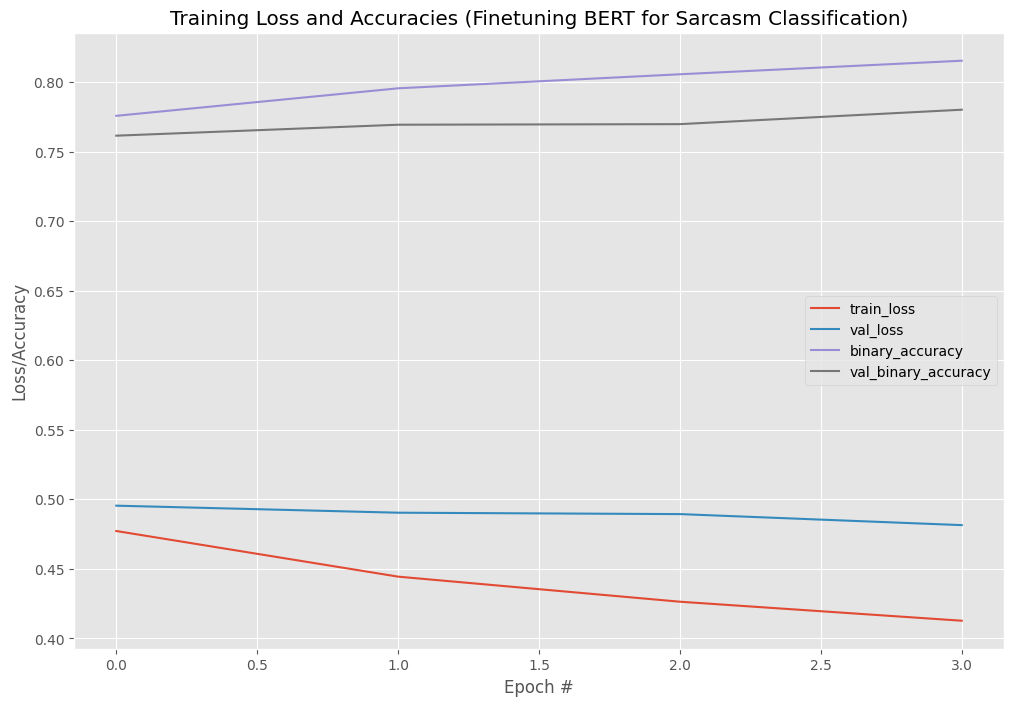

In [33]:
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history['binary_accuracy'], label="binary_accuracy")
plt.plot(N, history.history["val_binary_accuracy"], label="val_binary_accuracy")
plt.title("Training Loss and Accuracies (Finetuning BERT for Sarcasm Classification)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## Task 10: Evaluate the model

In this task, you’ll evaluate the model on the test set and get its accuracy, loss, and predictions. To complete the task, perform the following steps:

1. Use the evaluate() method of Keras on the classifier_model to get the loss and accuracy on the test set. This method accepts the following inputs:

x: These are the input sequences, i.e., the text column of the testing dataset.
    
y: These are one-hot encoded vectors of the target labels.
    
2. Use the predict() method of Keras to make class predictions. This method takes the input sequence as input and outputs class probabilities. 
To convert these probabilities into classes, use the np.argmax() method.
    

In [34]:
loss, accuracy = classifier_model.evaluate(X_test, pd.get_dummies(Y_test["labels"]))

print('Loss: ', loss)
print('Accuracy: ', accuracy)

76/76 [==============================] - 11s 146ms/step - loss: 0.4782 - binary_accuracy: 0.7850
Loss:  0.47817733883857727
Accuracy:  0.7849730253219604


In [35]:
actuals = Y_test["labels"]
Y_predicted = classifier_model.predict(X_test)
predictions= np.argmax(Y_predicted,axis=1)

76/76 [==============================] - 12s 147ms/step


## Task 11: Create a Confusion Matrix

In this task, you’ll create a confusion matrix to display the class predictions in graphical form.

To complete this task, perform the following steps:

1. Create a confusion matrix using the confusion_matrix() method from sklearn. This method requires the actual and class predictions as arguments.

2. Set the figure size using the plt.figure() method. This method accepts the argument figsize, which is a tuple of length 2.

3. Display the confusion matrix using seaborn’s heatmap() method. This method accepts the following inputs:

data: This matrix will be plotted as a heatmap.
    
annot: This is a boolean that determines if the values of each cell will be printed in the heatmap.

fmt: This string determines the format of the printed values.
    
4. Label the y-axis as true and the x-axis as predicted.


Text(20.72222222222222, 0.5, 'True')

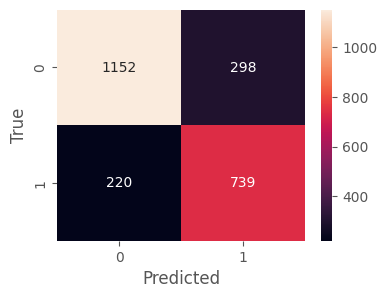

In [36]:
cm = confusion_matrix(actuals, predictions)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

## Task 12: Generate the Classification Report

In this task, you’ll generate a classification report. To complete this task, perform the following steps:

1. Use the classification_report() method from sklearn to generate a classification report. This method computes various classification metrics, such as
accuracy, precision, recall, and F1-score. This function takes the following arguments:

y_true: These are the actual labels from the dataset.

y_pred: These are the predicted targets the classifier gives.
    
target_names: This is a list of labels, i.e., the class names.

2. Print the classification report.


In [38]:
target_names = ['Non-Sarcastic', "Sarcastic"]
print(classification_report(actuals, predictions, target_names=target_names))

               precision    recall  f1-score   support

Non-Sarcastic       0.84      0.79      0.82      1450
    Sarcastic       0.71      0.77      0.74       959

     accuracy                           0.78      2409
    macro avg       0.78      0.78      0.78      2409
 weighted avg       0.79      0.78      0.79      2409

